# Entity Recognition with LLMs

<div align="left">
<a target="_blank" href="https://console.anyscale.com/"><img src="https://img.shields.io/badge/🚀 Run_on-Anyscale-9hf"></a>&nbsp;
<a href="https://github.com/anyscale/e2e-llm-workflows" role="button"><img src="https://img.shields.io/static/v1?label=&amp;message=View%20On%20GitHub&amp;color=586069&amp;logo=github&amp;labelColor=2f363d"></a>&nbsp;
</div>

An end-to-end tutorial where we'll fine-tune an LLM to perform batch inference and online serving at scale. While entity recognition is the main task, we can easily extend these end-to-end workflows to any use case.

<img src="https://raw.githubusercontent.com/anyscale/e2e-llm-workflows/refs/heads/main/images/e2e_llm.png" width=800>

**Note**: the intent of this tutorial is to show how Ray can be use to implement end-to-end LLM workflows that can extend to any use case. 

## Set up

### Compute
This [Anyscale Workspace](https://docs.anyscale.com/platform/workspaces/) will automatically provision and autoscale the compute our workloads will need. If you're not on Anyscale, then you will need to provision `4xA10G:48CPU-192GB` for this tutorial.

<img src="https://raw.githubusercontent.com/anyscale/foundational-ray-app/refs/heads/main/images/compute.png" width=500>

### Dependencies
Let's start by downloading the dependencies required for this tutorial. You'll notice in our [`containerfile`](https://raw.githubusercontent.com/anyscale/e2e-llm-workflows/refs/heads/main/containerfile) we have a base image `FROM anyscale/ray:2.44.1-py312-cu125` followed by a list of pip packages. If you're not on any [Anyscale](https://console.anyscale.com/), you can pull this docker image yourself and install the dependencies.


In [1]:
%%bash
# Install dependencies
pip install -q \
    "ray[serve,llm]>=2.44.0" \
    "vllm>=0.7.2" \
    "xgrammar==0.1.11" \
    "pynvml==12.0.0" \
    "hf_transfer==0.1.9" \
    "tensorboard" \
    "llamafactory @ git+https://github.com/hiyouga/LLaMA-Factory.git#egg=llamafactory"

Successfully registered `ray, vllm` and 5 other packages to be installed on all cluster nodes.
View and update dependencies here: https://console.anyscale.com/cld_kvedZWag2qA8i5BjxUevf5i7/prj_cz951f43jjdybtzkx1s5sjgz99/workspaces/expwrk_mp8cxvgle2yeumgcpu1yua2r3e?workspace-tab=dependencies


## Data

In [2]:
import json
import requests
import textwrap
from IPython.display import Code, Image, display

We'll start by downloading our data from cloud storage to local shared storage. 

In [3]:
%%bash
rm -rf /mnt/cluster_storage/viggo  # clean up
aws s3 cp  s3://viggo-ds/train.jsonl /mnt/cluster_storage/viggo/
aws s3 cp  s3://viggo-ds/val.jsonl /mnt/cluster_storage/viggo/
aws s3 cp  s3://viggo-ds/test.jsonl /mnt/cluster_storage/viggo/
aws s3 cp  s3://viggo-ds/dataset_info.json /mnt/cluster_storage/viggo/

download: s3://viggo-ds/train.jsonl to ../../../mnt/cluster_storage/viggo/train.jsonl
download: s3://viggo-ds/val.jsonl to ../../../mnt/cluster_storage/viggo/val.jsonl
download: s3://viggo-ds/test.jsonl to ../../../mnt/cluster_storage/viggo/test.jsonl
download: s3://viggo-ds/dataset_info.json to ../../../mnt/cluster_storage/viggo/dataset_info.json


In [4]:
%%bash
head -n 1 /mnt/cluster_storage/viggo/train.jsonl | python3 -m json.tool

{
    "instruction": "Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values. This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute']. The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']",
    "input": "Blizzard North is mostly an okay developer, but they released Diablo II for the Mac and so that pushes the game from okay to good in my view.",
    "output": "give_opinion(name[Diablo II], developer[Blizzard North], rating[good], has_mac_release[yes])"
}


In [5]:
with open("/mnt/cluster_storage/viggo/train.jsonl", "r") as fp:
    first_line = fp.readline()
    item = json.loads(first_line)
system_content = item["instruction"]
print(textwrap.fill(system_content, width=80))

Given a target sentence construct the underlying meaning representation of the
input sentence as a single function with attributes and attribute values. This
function should describe the target string accurately and the function must be
one of the following ['inform', 'request', 'give_opinion', 'confirm',
'verify_attribute', 'suggest', 'request_explanation', 'recommend',
'request_attribute']. The attributes must be one of the following: ['name',
'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres',
'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam',
'has_linux_release', 'has_mac_release', 'specifier']


We also have an info file that identifies the datasets and format --- alpaca and sharegpt (great for multimodal tasks) formats are supported --- to use for post training.

In [6]:
display(Code(filename="/mnt/cluster_storage/viggo/dataset_info.json", language="json"))

{
    "viggo-train": {
        "file_name": "/mnt/cluster_storage/viggo/train.jsonl",
        "formatting": "alpaca",
        "columns": {
            "prompt": "instruction",
            "query": "input",
            "response": "output"
        }
    },
    "viggo-val": {
        "file_name": "/mnt/cluster_storage/viggo/val.jsonl",
        "formatting": "alpaca",
        "columns": {
            "prompt": "instruction",
            "query": "input",
            "response": "output"
        }
    }
}

## Distributed fine-tuning

We'll use [Ray Train](https://docs.ray.io/en/latest/train/train.html) + [LLaMA-Factory](https://github.com/hiyouga/LLaMA-Factory) to peform multinode training. The parameters for our training workload -- post-training method, dataset location, train/val details, etc. --- can be found in the `llama3_lora_sft_ray.yaml` config file. Check out recipes for even more post-training methods (sft, pretraining, ppo, dpo, kto, etc.) [here](https://github.com/hiyouga/LLaMA-Factory/tree/main/examples).

**Note**: We also support using other tools like [axolotl](https://axolotl-ai-cloud.github.io/axolotl/docs/ray-integration.html) or even [Ray Train + HF Accelreate + FSDP/Deepspeed](https://docs.ray.io/en/latest/train/huggingface-accelerate.html) directly for complete control of your post-training workloads.

<img src="https://raw.githubusercontent.com/anyscale/foundational-ray-app/refs/heads/main/images/distributed_training.png" width=800>

In [7]:
import os
from pathlib import Path
import yaml

In [22]:
display(Code(filename="lora_sft_ray.yaml", language="yaml"))

### model
model_name_or_path: Qwen/Qwen2.5-7B-Instruct
trust_remote_code: true

### method
stage: sft
do_train: true
finetuning_type: lora
lora_rank: 8
lora_target: all

### dataset
dataset: viggo-train
dataset_dir: /mnt/cluster_storage/viggo  # shared storage workers have access to
template: qwen
cutoff_len: 2048
max_samples: 1000
overwrite_cache: true
preprocessing_num_workers: 16
dataloader_num_workers: 4

### output
output_dir: /mnt/cluster_storage/viggo/outputs  # should be somewhere workers have access to (ex. s3, nfs)
logging_steps: 10
save_steps: 500
plot_loss: true
overwrite_output_dir: true
save_only_model: false

### ray
ray_run_name: lora_sft_ray
ray_storage_path: /mnt/cluster_storage/viggo/saves  # should be somewhere workers have access to (ex. s3, nfs)
ray_num_workers: 4
resources_per_worker:
  GPU: 1
  anyscale/accelerator_shape:4xA10G: 1  # Use this to specify a specific node shape,
  # accelerator_type:A10G: 1           # Or use this to simply specify a GPU type.
  # see https://docs.ray.io/en/master/ray-core/accelerator-types.html#accelerator-types for a full list of accelerator types
placement_strategy: PACK

### train
per_device_train_batch_size: 1
gradient_accumulation_steps: 8
learning_rate: 1.0e-4
num_train_epochs: 5.0
lr_scheduler_type: cosine
warmup_ratio: 0.1
bf16: true
ddp_timeout: 180000000
resume_from_checkpoint: null

### eval
eval_dataset: viggo-val  # uses same dataset_dir as training data
# val_size: 0.1  # only if using part of training data for validation
per_device_eval_batch_size: 1
eval_strategy: steps
eval_steps: 500

In [23]:
model_id = "ft-model"  # call it whatever you want
model_source = yaml.safe_load(open("lora_sft_ray.yaml"))["model_name_or_path"]  # HF model ID, S3 mirror config, or GCS mirror config
print (model_source)

Qwen/Qwen2.5-7B-Instruct


In [24]:
%%bash
# Run multinode distributed fine-tuning workload
USE_RAY=1 llamafactory-cli train lora_sft_ray.yaml

INFO 04-11 14:47:34 __init__.py:194] No platform detected, vLLM is running on UnspecifiedPlatform


2025-04-11 14:47:37,753	INFO worker.py:1660 -- Connecting to existing Ray cluster at address: 10.0.51.51:6379...
2025-04-11 14:47:37,763	INFO worker.py:1843 -- Connected to Ray cluster. View the dashboard at https://session-zt5t77xa58pyp3uy28glg2g24d.i.anyscaleuserdata.com 
2025-04-11 14:47:37,768	INFO packaging.py:367 -- Pushing file package 'gcs://_ray_pkg_92dfd12481e31b6eb199fb90a473373c5d0517d0.zip' (2.07MiB) to Ray cluster...
2025-04-11 14:47:37,776	INFO packaging.py:380 -- Successfully pushed file package 'gcs://_ray_pkg_92dfd12481e31b6eb199fb90a473373c5d0517d0.zip'.



View detailed results here: /mnt/cluster_storage/viggo/saves/lora_sft_ray
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-04-11_12-25-06_198434_2329/artifacts/2025-04-11_14-47-37/lora_sft_ray/driver_artifacts`
(autoscaler +5s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +5s) [autoscaler] [4xA10G:48CPU-192GB] Attempting to add 4 node(s) to the cluster (increasing from 0 to 4).
(autoscaler +10s) [autoscaler] [4xA10G:48CPU-192GB] Launched 4 instances.
(autoscaler +1m10s) [autoscaler] Cluster upscaled to {144 CPU, 12 GPU}.
(autoscaler +1m20s) [autoscaler] Cluster upscaled to {192 CPU, 16 GPU}.

Training started with configuration:
╭──────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Training config                                                                                      │
├──────────────────────────────

(RayTrainWorker pid=3642, ip=10.0.43.196) Setting up process group for: env:// [rank=0, world_size=4]
(TorchTrainer pid=3542, ip=10.0.43.196) Started distributed worker processes: 
(TorchTrainer pid=3542, ip=10.0.43.196) - (node_id=61ef86792074e157decb04aa5faedf0599ddccc3b80160cc438180f6, ip=10.0.43.196, pid=3642) world_rank=0, local_rank=0, node_rank=0
(TorchTrainer pid=3542, ip=10.0.43.196) - (node_id=37efbd8717d58d4f73129d108f3d5a40e5601eed33b5a23fab9af900, ip=10.0.46.205, pid=3407) world_rank=1, local_rank=0, node_rank=1
(TorchTrainer pid=3542, ip=10.0.43.196) - (node_id=6441c36a31e630f348b2ebf6ced9a0430984987bab9dc55260429f50, ip=10.0.33.71, pid=3422) world_rank=2, local_rank=0, node_rank=2
(TorchTrainer pid=3542, ip=10.0.43.196) - (node_id=9e38d9685dceeb0086537b38003bf61b40836a10d8b0272e32e63656, ip=10.0.16.199, pid=3399) world_rank=3, local_rank=0, node_rank=3


(RayTrainWorker pid=3407, ip=10.0.46.205) [WARNING|2025-04-11 14:49:30] llamafactory.hparams.parser:148 >> `ddp_find_unused_parameters` needs to be set as False for LoRA in DDP training.
(RayTrainWorker pid=3407, ip=10.0.46.205) [INFO|2025-04-11 14:49:30] llamafactory.hparams.parser:379 >> Process rank: 1, world size: 4, device: cuda:0, distributed training: True, compute dtype: torch.bfloat16


(RayTrainWorker pid=3399, ip=10.0.16.199) [INFO|tokenization_utils_base.py:2050] 2025-04-11 14:49:31,890 >> loading file vocab.json from cache at /home/ray/.cache/huggingface/hub/models--Qwen--Qwen2.5-7B-Instruct/snapshots/a09a35458c702b33eeacc393d103063234e8bc28/vocab.json
(RayTrainWorker pid=3399, ip=10.0.16.199) [INFO|tokenization_utils_base.py:2050] 2025-04-11 14:49:31,890 >> loading file merges.txt from cache at /home/ray/.cache/huggingface/hub/models--Qwen--Qwen2.5-7B-Instruct/snapshots/a09a35458c702b33eeacc393d103063234e8bc28/merges.txt
(RayTrainWorker pid=3399, ip=10.0.16.199) [INFO|tokenization_utils_base.py:2050] 2025-04-11 14:49:31,890 >> loading file tokenizer.json from cache at /home/ray/.cache/huggingface/hub/models--Qwen--Qwen2.5-7B-Instruct/snapshots/a09a35458c702b33eeacc393d103063234e8bc28/tokenizer.json
(RayTrainWorker pid=3399, ip=10.0.16.199) [INFO|tokenization_utils_base.py:2050] 2025-04-11 14:49:31,890 >> loading file added_tokens.json from cache at None
(RayTrain

(RayTrainWorker pid=3399, ip=10.0.16.199) [INFO|2025-04-11 14:49:33] llamafactory.data.template:143 >> Add <|im_end|> to stop words.
(RayTrainWorker pid=3399, ip=10.0.16.199) [INFO|2025-04-11 14:49:33] llamafactory.data.loader:143 >> Loading dataset /mnt/cluster_storage/viggo/train.jsonl...


(RayTrainWorker pid=3642, ip=10.0.43.196)     "Qwen2ForCausalLM"
(RayTrainWorker pid=3642, ip=10.0.43.196) 
(RayTrainWorker pid=3407, ip=10.0.46.205)     "Qwen2ForCausalLM"
(RayTrainWorker pid=3407, ip=10.0.46.205) 
(RayTrainWorker pid=3399, ip=10.0.16.199) Setting num_proc from 16 back to 1 for the train split to disable multiprocessing as it only contains one shard.
Generating train split: 0 examples [00:00, ? examples/s]
Generating train split: 10206 examples [00:00, 100953.16 examples/s]
Converting format of dataset (num_proc=16): 100%|██████████| 1000/1000 [00:00<00:00, 4694.45 examples/s]


(RayTrainWorker pid=3422, ip=10.0.33.71) [INFO|2025-04-11 14:49:34] llamafactory.data.loader:143 >> Loading dataset /mnt/cluster_storage/viggo/val.jsonl...


Generating train split: 714 examples [00:00, 92888.74 examples/s]
Converting format of dataset (num_proc=16): 100%|██████████| 1000/1000 [00:00<00:00, 1372.46 examples/s]
(RayTrainWorker pid=3422, ip=10.0.33.71) [rank2]:[W411 14:49:35.921940742 ProcessGroupNCCL.cpp:4115] [PG ID 0 PG GUID 0 Rank 2]  using GPU 0 to perform barrier as devices used by this process are currently unknown. This can potentially cause a hang if this rank to GPU mapping is incorrect.Specify device_ids in barrier() to force use of a particular device,or call init_process_group() with a device_id.
Running tokenizer on dataset (num_proc=16):   0%|          | 0/1000 [00:00<?, ? examples/s]
(RayTrainWorker pid=3642, ip=10.0.43.196) [INFO|tokenization_utils_base.py:2050] 2025-04-11 14:49:33,287 >> loading file vocab.json from cache at /home/ray/.cache/huggingface/hub/models--Qwen--Qwen2.5-7B-Instruct/snapshots/a09a35458c702b33eeacc393d103063234e8bc28/vocab.json [repeated 7x across cluster] (Ray deduplicates logs by de

(RayTrainWorker pid=3422, ip=10.0.33.71) training example:
(RayTrainWorker pid=3422, ip=10.0.33.71) input_ids:
(RayTrainWorker pid=3422, ip=10.0.33.71) [151644, 8948, 198, 2610, 525, 1207, 16948, 11, 3465, 553, 54364, 14817, 13, 1446, 525, 264, 10950, 17847, 13, 151645, 198, 151644, 872, 198, 22043, 264, 2169, 11652, 9245, 279, 16533, 7290, 13042, 315, 279, 1946, 11652, 438, 264, 3175, 729, 448, 8201, 323, 7035, 2750, 13, 1096, 729, 1265, 7512, 279, 2169, 914, 29257, 323, 279, 729, 1969, 387, 825, 315, 279, 2701, 2509, 40440, 516, 364, 2035, 516, 364, 46430, 10287, 36300, 516, 364, 13800, 516, 364, 12446, 16791, 516, 364, 95761, 516, 364, 2035, 2702, 35890, 516, 364, 66589, 516, 364, 2035, 16791, 7204, 576, 8201, 1969, 387, 825, 315, 279, 2701, 25, 2509, 606, 516, 364, 4580, 24577, 4164, 516, 364, 22998, 14645, 516, 364, 34401, 516, 364, 288, 10681, 516, 364, 21931, 516, 364, 63911, 516, 364, 3434, 620, 85091, 516, 364, 4648, 25133, 3434, 516, 364, 15734, 82, 516, 364, 10334, 4470, 126

Converting format of dataset (num_proc=16): 100%|██████████| 714/714 [00:00<00:00, 2957.84 examples/s] [repeated 7x across cluster]
Generating train split: 714 examples [00:00, 96885.57 examples/s] [repeated 3x across cluster]
(RayTrainWorker pid=3407, ip=10.0.46.205) [rank1]:[W411 14:49:35.520539128 ProcessGroupNCCL.cpp:4115] [PG ID 0 PG GUID 0 Rank 1]  using GPU 0 to perform barrier as devices used by this process are currently unknown. This can potentially cause a hang if this rank to GPU mapping is incorrect.Specify device_ids in barrier() to force use of a particular device,or call init_process_group() with a device_id. [repeated 3x across cluster]


(RayTrainWorker pid=3422, ip=10.0.33.71) eval example:
(RayTrainWorker pid=3407, ip=10.0.46.205) [INFO|2025-04-11 14:49:35] llamafactory.data.loader:143 >> Loading dataset /mnt/cluster_storage/viggo/val.jsonl... [repeated 3x across cluster]
(RayTrainWorker pid=3422, ip=10.0.33.71) [151644, 8948, 198, 2610, 525, 1207, 16948, 11, 3465, 553, 54364, 14817, 13, 1446, 525, 264, 10950, 17847, 13, 151645, 198, 151644, 872, 198, 22043, 264, 2169, 11652, 9245, 279, 16533, 7290, 13042, 315, 279, 1946, 11652, 438, 264, 3175, 729, 448, 8201, 323, 7035, 2750, 13, 1096, 729, 1265, 7512, 279, 2169, 914, 29257, 323, 279, 729, 1969, 387, 825, 315, 279, 2701, 2509, 40440, 516, 364, 2035, 516, 364, 46430, 10287, 36300, 516, 364, 13800, 516, 364, 12446, 16791, 516, 364, 95761, 516, 364, 2035, 2702, 35890, 516, 364, 66589, 516, 364, 2035, 16791, 7204, 576, 8201, 1969, 387, 825, 315, 279, 2701, 25, 2509, 606, 516, 364, 4580, 24577, 4164, 516, 364, 22998, 14645, 516, 364, 34401, 516, 364, 288, 10681, 516, 364

(RayTrainWorker pid=3399, ip=10.0.16.199)     "Qwen2ForCausalLM"
(RayTrainWorker pid=3399, ip=10.0.16.199) 


(RayTrainWorker pid=3399, ip=10.0.16.199) [INFO|2025-04-11 14:49:41] llamafactory.model.model_utils.kv_cache:143 >> KV cache is disabled during training.


(RayTrainWorker pid=3422, ip=10.0.33.71)     "Qwen2ForCausalLM"
(RayTrainWorker pid=3422, ip=10.0.33.71) 
(RayTrainWorker pid=3642, ip=10.0.43.196)     "Qwen2ForCausalLM"
(RayTrainWorker pid=3642, ip=10.0.43.196) 
(RayTrainWorker pid=3407, ip=10.0.46.205)     "Qwen2ForCausalLM"
(RayTrainWorker pid=3407, ip=10.0.46.205) 
(RayTrainWorker pid=3422, ip=10.0.33.71) [INFO|modeling_utils.py:3982] 2025-04-11 14:49:42,135 >> loading weights file model.safetensors from cache at /home/ray/.cache/huggingface/hub/models--Qwen--Qwen2.5-7B-Instruct/snapshots/a09a35458c702b33eeacc393d103063234e8bc28/model.safetensors.index.json
Running tokenizer on dataset (num_proc=16):  82%|████████▏ | 582/714 [00:01<00:00, 509.95 examples/s] [repeated 55x across cluster]
(RayTrainWorker pid=3407, ip=10.0.46.205) [INFO|configuration_utils.py:699] 2025-04-11 14:49:41,581 >> loading configuration file config.json from cache at /home/ray/.cache/huggingface/hub/models--Qwen--Qwen2.5-7B-Instruct/snapshots/a09a35458c702b3

(RayTrainWorker pid=3642, ip=10.0.43.196) [INFO|2025-04-11 14:50:02] llamafactory.model.model_utils.checkpointing:143 >> Gradient checkpointing enabled.
(RayTrainWorker pid=3642, ip=10.0.43.196) [INFO|2025-04-11 14:50:02] llamafactory.model.model_utils.attention:143 >> Using torch SDPA for faster training and inference.
(RayTrainWorker pid=3642, ip=10.0.43.196) [INFO|2025-04-11 14:50:02] llamafactory.model.adapter:143 >> Upcasting trainable params to float32.
(RayTrainWorker pid=3642, ip=10.0.43.196) [INFO|2025-04-11 14:50:02] llamafactory.model.adapter:143 >> Fine-tuning method: LoRA
(RayTrainWorker pid=3642, ip=10.0.43.196) [INFO|2025-04-11 14:50:02] llamafactory.model.model_utils.misc:143 >> Found linear modules: q_proj,v_proj,k_proj,o_proj,down_proj,gate_proj,up_proj
(RayTrainWorker pid=3642, ip=10.0.43.196) training example: [repeated 3x across cluster]
(RayTrainWorker pid=3399, ip=10.0.16.199) input_ids: [repeated 7x across cluster]
(RayTrainWorker pid=3642, ip=10.0.43.196) input

(RayTrainWorker pid=3642, ip=10.0.43.196) [INFO|configuration_utils.py:1095] 2025-04-11 14:50:02,539 >> loading configuration file generation_config.json from cache at /home/ray/.cache/huggingface/hub/models--Qwen--Qwen2.5-7B-Instruct/snapshots/a09a35458c702b33eeacc393d103063234e8bc28/generation_config.json
(RayTrainWorker pid=3642, ip=10.0.43.196)   "do_sample": true,
(RayTrainWorker pid=3642, ip=10.0.43.196)   "eos_token_id": [
(RayTrainWorker pid=3642, ip=10.0.43.196)     151645,
(RayTrainWorker pid=3642, ip=10.0.43.196)     151643
(RayTrainWorker pid=3642, ip=10.0.43.196)   ],
(RayTrainWorker pid=3642, ip=10.0.43.196)   "pad_token_id": 151643,
(RayTrainWorker pid=3642, ip=10.0.43.196)   "repetition_penalty": 1.05,
(RayTrainWorker pid=3642, ip=10.0.43.196)   "temperature": 0.7,
(RayTrainWorker pid=3642, ip=10.0.43.196)   "top_k": 20,
(RayTrainWorker pid=3642, ip=10.0.43.196)   "top_p": 0.8
(RayTrainWorker pid=3642, ip=10.0.43.196) 
(RayTrainWorker pid=3407, ip=10.0.46.205)     15164

(RayTrainWorker pid=3407, ip=10.0.46.205) [INFO|2025-04-11 14:50:02] llamafactory.model.model_utils.misc:143 >> Found linear modules: o_proj,v_proj,up_proj,q_proj,gate_proj,k_proj,down_proj
(RayTrainWorker pid=3642, ip=10.0.43.196) [INFO|2025-04-11 14:50:02] llamafactory.model.loader:143 >> trainable params: 20,185,088 || all params: 7,635,801,600 || trainable%: 0.2643


(RayTrainWorker pid=3642, ip=10.0.43.196) [INFO|trainer.py:746] 2025-04-11 14:50:02,946 >> Using auto half precision backend
(RayTrainWorker pid=3642, ip=10.0.43.196) [WARNING|trainer.py:781] 2025-04-11 14:50:02,947 >> No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
(RayTrainWorker pid=3407, ip=10.0.46.205) [INFO|modeling_utils.py:1633] 2025-04-11 14:49:58,951 >> Instantiating Qwen2ForCausalLM model under default dtype torch.bfloat16.
(RayTrainWorker pid=3407, ip=10.0.46.205) [INFO|configuration_utils.py:1140] 2025-04-11 14:50:02,775 >> Generate config GenerationConfig { [repeated 3x across cluster]
(RayTrainWorker pid=3407, ip=10.0.46.205)   "bos_token_id": 151643, [repeated 3x across cluster]
(RayTrainWorker pid=3407, ip=10.0.46.205)   "eos_token_id": 151645,
(RayTrainWorker pi

(RayTrainWorker pid=3399, ip=10.0.16.199) [INFO|2025-04-11 14:50:42] llamafactory.model.model_utils.misc:143 >> Found linear modules: k_proj,gate_proj,v_proj,up_proj,o_proj,q_proj,down_proj
(RayTrainWorker pid=3399, ip=10.0.16.199) [INFO|2025-04-11 14:50:42] llamafactory.model.model_utils.checkpointing:143 >> Gradient checkpointing enabled. [repeated 2x across cluster]
(RayTrainWorker pid=3399, ip=10.0.16.199) [INFO|2025-04-11 14:50:42] llamafactory.model.model_utils.attention:143 >> Using torch SDPA for faster training and inference. [repeated 2x across cluster]
(RayTrainWorker pid=3399, ip=10.0.16.199) [INFO|2025-04-11 14:50:42] llamafactory.model.adapter:143 >> Upcasting trainable params to float32. [repeated 2x across cluster]
(RayTrainWorker pid=3399, ip=10.0.16.199) [INFO|2025-04-11 14:50:42] llamafactory.model.adapter:143 >> Fine-tuning method: LoRA [repeated 2x across cluster]
(RayTrainWorker pid=3407, ip=10.0.46.205) [INFO|2025-04-11 14:50:03] llamafactory.model.loader:143 >> 

(RayTrainWorker pid=3422, ip=10.0.33.71)     151645,
(RayTrainWorker pid=3422, ip=10.0.33.71)     151643
(RayTrainWorker pid=3422, ip=10.0.33.71) 


(RayTrainWorker pid=3422, ip=10.0.33.71) [INFO|2025-04-11 14:50:42] llamafactory.model.model_utils.misc:143 >> Found linear modules: k_proj,up_proj,gate_proj,o_proj,q_proj,v_proj,down_proj
(RayTrainWorker pid=3422, ip=10.0.33.71) [INFO|2025-04-11 14:50:42] llamafactory.model.loader:143 >> trainable params: 20,185,088 || all params: 7,635,801,600 || trainable%: 0.2643


(RayTrainWorker pid=3399, ip=10.0.16.199) [INFO|trainer.py:746] 2025-04-11 14:50:42,859 >> Using auto half precision backend
(RayTrainWorker pid=3399, ip=10.0.16.199) [WARNING|trainer.py:781] 2025-04-11 14:50:42,860 >> No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
(RayTrainWorker pid=3399, ip=10.0.16.199) [INFO|trainer.py:2405] 2025-04-11 14:50:45,258 >> ***** Running training *****
(RayTrainWorker pid=3399, ip=10.0.16.199) [INFO|trainer.py:2406] 2025-04-11 14:50:45,259 >>   Num examples = 1,000
(RayTrainWorker pid=3399, ip=10.0.16.199) [INFO|trainer.py:2407] 2025-04-11 14:50:45,259 >>   Num Epochs = 5
(RayTrainWorker pid=3399, ip=10.0.16.199) [INFO|trainer.py:2408] 2025-04-11 14:50:45,259 >>   Instantaneous batch size per device = 1
(RayTrainWorker pid=3399, ip=10.0.16.199) [I

(RayTrainWorker pid=3642, ip=10.0.43.196) {'loss': 2.0486, 'grad_norm': 3.5621888637542725, 'learning_rate': 6.25e-05, 'epoch': 0.32}
(RayTrainWorker pid=3422, ip=10.0.33.71) [INFO|2025-04-11 14:50:42] llamafactory.model.model_utils.checkpointing:143 >> Gradient checkpointing enabled.
(RayTrainWorker pid=3422, ip=10.0.33.71) [INFO|2025-04-11 14:50:42] llamafactory.model.model_utils.attention:143 >> Using torch SDPA for faster training and inference.
(RayTrainWorker pid=3422, ip=10.0.33.71) [INFO|2025-04-11 14:50:42] llamafactory.model.adapter:143 >> Upcasting trainable params to float32.
(RayTrainWorker pid=3422, ip=10.0.33.71) [INFO|2025-04-11 14:50:42] llamafactory.model.adapter:143 >> Fine-tuning method: LoRA
(RayTrainWorker pid=3399, ip=10.0.16.199) [INFO|2025-04-11 14:50:42] llamafactory.model.loader:143 >> trainable params: 20,185,088 || all params: 7,635,801,600 || trainable%: 0.2643


 12%|█▏        | 19/155 [00:54<06:19,  2.79s/it]0m 


(RayTrainWorker pid=3642, ip=10.0.43.196) {'loss': 0.6259, 'grad_norm': 1.2032835483551025, 'learning_rate': 9.979581007037776e-05, 'epoch': 0.64}


 19%|█▊        | 29/155 [01:22<05:49,  2.77s/it]0m 


(RayTrainWorker pid=3642, ip=10.0.43.196) {'loss': 0.2292, 'grad_norm': 0.4791054427623749, 'learning_rate': 9.751778332739033e-05, 'epoch': 0.96}


 25%|██▌       | 39/155 [01:49<05:29,  2.84s/it]0m 


(RayTrainWorker pid=3642, ip=10.0.43.196) {'loss': 0.1038, 'grad_norm': 0.4758801758289337, 'learning_rate': 9.282275574435281e-05, 'epoch': 1.26}


 32%|███▏      | 49/155 [02:18<05:01,  2.85s/it]0m 


(RayTrainWorker pid=3642, ip=10.0.43.196) {'loss': 0.0642, 'grad_norm': 0.7475855946540833, 'learning_rate': 8.594954076788736e-05, 'epoch': 1.58}


 38%|███▊      | 59/155 [02:46<04:33,  2.85s/it]0m 


(RayTrainWorker pid=3642, ip=10.0.43.196) {'loss': 0.0442, 'grad_norm': 0.5265139937400818, 'learning_rate': 7.724774574936188e-05, 'epoch': 1.9}


 45%|████▍     | 69/155 [03:12<03:53,  2.71s/it]0m 


(RayTrainWorker pid=3642, ip=10.0.43.196) {'loss': 0.025, 'grad_norm': 0.24590221047401428, 'learning_rate': 6.715998910228296e-05, 'epoch': 2.19}


 51%|█████     | 79/155 [03:41<03:34,  2.82s/it]0m 


(RayTrainWorker pid=3642, ip=10.0.43.196) {'loss': 0.0126, 'grad_norm': 0.18876521289348602, 'learning_rate': 5.619938643480561e-05, 'epoch': 2.51}


 57%|█████▋    | 89/155 [04:10<03:06,  2.82s/it]0m 


(RayTrainWorker pid=3642, ip=10.0.43.196) {'loss': 0.0176, 'grad_norm': 0.18610309064388275, 'learning_rate': 4.4923450829394605e-05, 'epoch': 2.83}


 64%|██████▍   | 99/155 [04:36<02:28,  2.65s/it]0m 


(RayTrainWorker pid=3642, ip=10.0.43.196) {'loss': 0.0133, 'grad_norm': 0.2031596302986145, 'learning_rate': 3.390573483674142e-05, 'epoch': 3.13}


 71%|███████   | 110/155 [05:07<02:06,  2.81s/it]m 


(RayTrainWorker pid=3642, ip=10.0.43.196) {'loss': 0.0073, 'grad_norm': 0.18948839604854584, 'learning_rate': 2.3706656619162278e-05, 'epoch': 3.45}


 77%|███████▋  | 120/155 [05:35<01:39,  2.83s/it]m 


(RayTrainWorker pid=3642, ip=10.0.43.196) {'loss': 0.0088, 'grad_norm': 0.40255069732666016, 'learning_rate': 1.484499417709087e-05, 'epoch': 3.77}


 83%|████████▎ | 129/155 [05:59<01:05,  2.52s/it]m 


(RayTrainWorker pid=3642, ip=10.0.43.196) {'loss': 0.0106, 'grad_norm': 0.07644153386354446, 'learning_rate': 7.77149761010898e-06, 'epoch': 4.06}


 90%|█████████ | 140/155 [06:30<00:42,  2.81s/it]m 


(RayTrainWorker pid=3642, ip=10.0.43.196) {'loss': 0.0044, 'grad_norm': 0.11668023467063904, 'learning_rate': 2.8459616297395466e-06, 'epoch': 4.38}


 97%|█████████▋| 150/155 [06:58<00:14,  2.81s/it]m 


(RayTrainWorker pid=3642, ip=10.0.43.196) {'loss': 0.0065, 'grad_norm': 0.1428825855255127, 'learning_rate': 3.1892453488058803e-07, 'epoch': 4.7}


100%|██████████| 155/155 [07:12<00:00,  2.85s/it][INFO|trainer.py:3942] 2025-04-11 14:57:59,207 >> Saving model checkpoint to /mnt/cluster_storage/viggo/outputs/checkpoint-155
(RayTrainWorker pid=3407, ip=10.0.46.205) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/mnt/cluster_storage/viggo/saves/lora_sft_ray/TorchTrainer_95d16_00000_0_2025-04-11_14-47-37/checkpoint_000000)
(RayTrainWorker pid=3407, ip=10.0.46.205) [INFO|trainer.py:2657] 2025-04-11 14:57:59,293 >> 
(RayTrainWorker pid=3407, ip=10.0.46.205) 
(RayTrainWorker pid=3407, ip=10.0.46.205) Training completed. Do not forget to share your model on huggingface.co/models =)
(RayTrainWorker pid=3407, ip=10.0.46.205) 
(RayTrainWorker pid=3407, ip=10.0.46.205) 
(RayTrainWorker pid=3422, ip=10.0.33.71) 
(RayTrainWorker pid=3422, ip=10.0.33.71) 
(RayTrainWorker pid=3422, ip=10.0.33.71) 
(RayTrainWorker pid=3399, ip=10.0.16.199) 
(RayTrainWorker pid=3399, ip=10.0.16.199) 
(RayTrainWorker pid=3399, ip=10.0.16.199) 


Training finished iteration 1 at 2025-04-11 14:58:02. Total running time: 10min 24s
╭─────────────────────────────────────────╮
│ Training result                         │
├─────────────────────────────────────────┤
│ checkpoint_dir_name   checkpoint_000000 │
│ time_this_iter_s              521.83827 │
│ time_total_s                  521.83827 │
│ training_iteration                    1 │
│ epoch                             4.704 │
│ grad_norm                       0.14288 │
│ learning_rate                        0. │
│ loss                             0.0065 │
│ step                                150 │
╰─────────────────────────────────────────╯
Training saved a checkpoint for iteration 1 at: (local)/mnt/cluster_storage/viggo/saves/lora_sft_ray/TorchTrainer_95d16_00000_0_2025-04-11_14-47-37/checkpoint_000000


(RayTrainWorker pid=3422, ip=10.0.33.71) ***** Running Evaluation *****
(RayTrainWorker pid=3422, ip=10.0.33.71) [INFO|trainer.py:4260] 2025-04-11 14:58:02,793 >>   Num examples = 714
(RayTrainWorker pid=3422, ip=10.0.33.71) [INFO|trainer.py:4263] 2025-04-11 14:58:02,793 >>   Batch size = 1


(RayTrainWorker pid=3642, ip=10.0.43.196) {'train_runtime': 437.2951, 'train_samples_per_second': 11.434, 'train_steps_per_second': 0.354, 'train_loss': 0.2079355036479331, 'epoch': 4.86}


(RayTrainWorker pid=3642, ip=10.0.43.196) 
(RayTrainWorker pid=3642, ip=10.0.43.196) 
(RayTrainWorker pid=3642, ip=10.0.43.196) 
100%|██████████| 155/155 [07:16<00:00,  2.81s/it]m 
(RayTrainWorker pid=3642, ip=10.0.43.196) [INFO|trainer.py:3942] 2025-04-11 14:58:02,865 >> Saving model checkpoint to /mnt/cluster_storage/viggo/outputs
(RayTrainWorker pid=3642, ip=10.0.43.196) [INFO|configuration_utils.py:699] 2025-04-11 14:58:03,080 >> loading configuration file config.json from cache at /home/ray/.cache/huggingface/hub/models--Qwen--Qwen2.5-7B-Instruct/snapshots/a09a35458c702b33eeacc393d103063234e8bc28/config.json
(RayTrainWorker pid=3642, ip=10.0.43.196) [INFO|configuration_utils.py:771] 2025-04-11 14:58:03,081 >> Model config Qwen2Config {
(RayTrainWorker pid=3642, ip=10.0.43.196)   "architectures": [
(RayTrainWorker pid=3642, ip=10.0.43.196)     "Qwen2ForCausalLM"
(RayTrainWorker pid=3642, ip=10.0.43.196)   ],
(RayTrainWorker pid=3642, ip=10.0.43.196)   "attention_dropout": 0.0,
(Ray

(RayTrainWorker pid=3642, ip=10.0.43.196) ***** train metrics *****
(RayTrainWorker pid=3642, ip=10.0.43.196)   epoch                    =      4.864
(RayTrainWorker pid=3642, ip=10.0.43.196)   total_flos               = 45104871GF
(RayTrainWorker pid=3642, ip=10.0.43.196)   train_loss               =     0.2079
(RayTrainWorker pid=3642, ip=10.0.43.196)   train_runtime            = 0:07:17.29
(RayTrainWorker pid=3642, ip=10.0.43.196)   train_samples_per_second =     11.434
(RayTrainWorker pid=3642, ip=10.0.43.196)   train_steps_per_second   =      0.354
(RayTrainWorker pid=3642, ip=10.0.43.196) Figure saved at: /mnt/cluster_storage/viggo/outputs/training_loss.png
(RayTrainWorker pid=3642, ip=10.0.43.196) [WARNING|2025-04-11 14:58:03] llamafactory.extras.ploting:148 >> No metric eval_viggo-val_loss to plot.
(RayTrainWorker pid=3642, ip=10.0.43.196) [WARNING|2025-04-11 14:58:03] llamafactory.extras.ploting:148 >> No metric eval_viggo-val_accuracy to plot.


  0%|          | 0/179 [00:00<?, ?it/s]43.196) 
(RayTrainWorker pid=3642, ip=10.0.43.196) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/mnt/cluster_storage/viggo/saves/lora_sft_ray/TorchTrainer_95d16_00000_0_2025-04-11_14-47-37/checkpoint_000000) [repeated 3x across cluster]
(RayTrainWorker pid=3642, ip=10.0.43.196) [INFO|trainer.py:4258] 2025-04-11 14:58:03,997 >>  [repeated 7x across cluster]
(RayTrainWorker pid=3642, ip=10.0.43.196) Training completed. Do not forget to share your model on huggingface.co/models =) [repeated 3x across cluster]
 18%|█▊        | 32/179 [00:03<00:16,  8.94it/s]0m 
(RayTrainWorker pid=3642, ip=10.0.43.196) ***** Running Evaluation ***** [repeated 3x across cluster]
(RayTrainWorker pid=3642, ip=10.0.43.196) [INFO|trainer.py:4260] 2025-04-11 14:58:03,997 >>   Num examples = 714 [repeated 3x across cluster]
(RayTrainWorker pid=3642, ip=10.0.43.196) [INFO|trainer.py:4263] 2025-04-11 14:58:03,997 >>   Batch size = 1 [repeated 3x across

(RayTrainWorker pid=3642, ip=10.0.43.196) ***** eval metrics *****
(RayTrainWorker pid=3642, ip=10.0.43.196)   epoch                             =      4.864
(RayTrainWorker pid=3642, ip=10.0.43.196)   eval_viggo-val_loss               =     0.1362
(RayTrainWorker pid=3642, ip=10.0.43.196)   eval_viggo-val_runtime            = 0:00:20.27
(RayTrainWorker pid=3642, ip=10.0.43.196)   eval_viggo-val_samples_per_second =     35.208
(RayTrainWorker pid=3642, ip=10.0.43.196)   eval_viggo-val_steps_per_second   =      8.827


100%|██████████| 179/179 [00:19<00:00,  8.99it/s]m 
(RayTrainWorker pid=3642, ip=10.0.43.196) [INFO|modelcard.py:449] 2025-04-11 14:58:24,351 >> Dropping the following result as it does not have all the necessary fields:
(RayTrainWorker pid=3642, ip=10.0.43.196) {'task': {'name': 'Causal Language Modeling', 'type': 'text-generation'}}



Training completed after 1 iterations at 2025-04-11 14:58:26. Total running time: 10min 48s


2025-04-11 14:58:26,323	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/mnt/cluster_storage/viggo/saves/lora_sft_ray' in 0.0214s.


<div class="alert alert-block alert"> <b>Ray Train</b> 

Using [Ray Train](https://docs.ray.io/en/latest/train/train.html) here has several advantages:
- automatically handles **multi-node, multi-GPU** setup with no manual SSH setup or hostfile configs. 
- define **per-worker franctional resource requirements** (e.g., 2 CPUs and 0.5 GPU per worker)
- run on **heterogeneous machines** and scale flexibly (e.g., CPU for preprocessing and GPU for training) 
- built-in **fault tolerance** via retry of failed workers (and continue from last checkpoint).
- supports Data Parallel, Model Parallel, Parameter Server, and even custom strategies.
- [Ray Compiled graphs](https://docs.ray.io/en/latest/ray-core/compiled-graph/ray-compiled-graph.html) allow us to even define different parallelism for jointly optimizing multipe models (Megatron, Deepspeed, etc. only allow for one global setting).

[RayTurbo Train](https://docs.anyscale.com/rayturbo/rayturbo-train) offers even more improvement to the price-performance ratio, performance monitoring and more:
- **elastic training** to scale to a dynamic number of workers, continue training on fewer resources (even on spot instances).
- **purpose-built dashboard** designed to streamline the debugging of Ray Train workloads
    - Monitoring: View the status of training runs and train workers.
    - Metrics: See insights on training throughput, training system operation time.
    - Profiling: Investigate bottlenecks, hangs, or errors from individual training worker processes.

<img src="https://raw.githubusercontent.com/anyscale/foundational-ray-app/refs/heads/main/images/train_dashboard.png" width=700>

<div class="alert alert-block alert"> <b> 🔎 Monitoring and Debugging with Ray</b> 


OSS Ray offers an extensive [observability suite](https://docs.ray.io/en/latest/ray-observability/index.html) that offers logs and an observability dashboard that we can use to monitor and debug. The dashboard includes a lot of different components such as:

-  memory, utilization, etc. of the tasks running in our [cluster](https://docs.ray.io/en/latest/ray-observability/getting-started.html#dash-node-view)

<img src="https://raw.githubusercontent.com/anyscale/foundational-ray-app/refs/heads/main/images/cluster_util.png" width=700>

- views to see all our running tasks, utilization across instance types, autoscaling, etc.

<img src="https://raw.githubusercontent.com/anyscale/foundational-ray-app/refs/heads/main/images/observability_views.png" width=1000>


<div class="alert alert-block alert"> <b> 🔎➕➕ Monitoring and Debugging on Anyscale</b> 

While OSS Ray comes with an extensive obervability suite, Anyscale takes it many steps further to make it even easier and faster to monitor and debug your workloads.

- [unified log viewer](https://docs.anyscale.com/monitoring/accessing-logs/) to see logs from *all* our driver and worker processes
- Ray workload specific dashboard (Data, Train, etc.) that can breakdown the tasks. For example, our training workload above can be observed live through the Train specific Ray Workloads dashboard:

<img src="https://raw.githubusercontent.com/anyscale/e2e-llm-workflows/refs/heads/main/images/train_dashboard.png" width=700>




<div class="alert alert-block alert"> <b> 🗂️ Storage on Anyscale</b> 

We can always store to our data inside [any storage buckets](https://docs.anyscale.com/configuration/storage/#private-storage-buckets) but Anyscale offers a [default storage bucket](https://docs.anyscale.com/configuration/storage/#anyscale-default-storage-bucket) to make things even easier. We also have plenty of other [storage options](https://docs.anyscale.com/configuration/storage/) as well (shared at the cluster, user and cloud levels).

In [25]:
%%bash
# Anyscale default storage bucket
echo $ANYSCALE_ARTIFACT_STORAGE

s3://anyscale-test-data-cld-i2w99rzq8b6lbjkke9y94vi5/org_7c1Kalm9WcX2bNIjW53GUT/cld_kvedZWag2qA8i5BjxUevf5i7/artifact_storage


In [26]:
%%bash
# Save fine-tuning artifacts to cloud storage
aws s3 rm $ANYSCALE_ARTIFACT_STORAGE/viggo --recursive --quiet
aws s3 cp /mnt/cluster_storage/viggo/outputs $ANYSCALE_ARTIFACT_STORAGE/viggo/outputs --recursive --quiet
aws s3 cp $2 /mnt/cluster_storage/viggo/saves $ANYSCALE_ARTIFACT_STORAGE/viggo/saves --recursive --quiet

In [27]:
display(Code(filename="/mnt/cluster_storage/viggo/outputs/all_results.json", language="json"))

{
    "epoch": 4.864,
    "eval_viggo-val_loss": 0.13618840277194977,
    "eval_viggo-val_runtime": 20.2797,
    "eval_viggo-val_samples_per_second": 35.208,
    "eval_viggo-val_steps_per_second": 8.827,
    "total_flos": 4.843098686147789e+16,
    "train_loss": 0.2079355036479331,
    "train_runtime": 437.2951,
    "train_samples_per_second": 11.434,
    "train_steps_per_second": 0.354
}

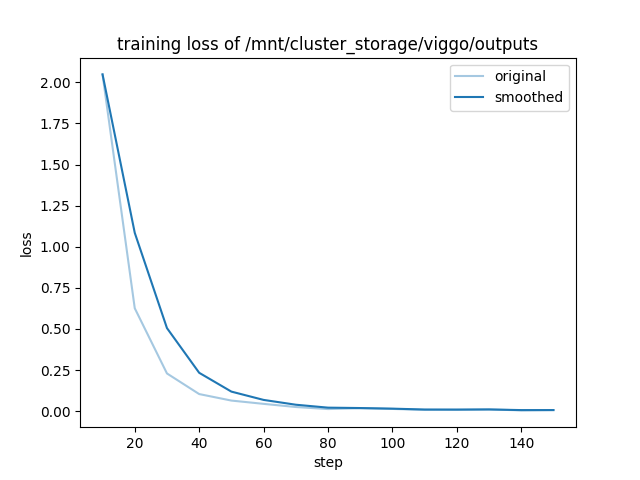

In [28]:
display(Image(filename="/mnt/cluster_storage/viggo/outputs/training_loss.png"))

In [29]:
%%bash
ls /mnt/cluster_storage/viggo/saves/lora_sft_ray

TorchTrainer_95d16_00000_0_2025-04-11_14-47-37
TorchTrainer_f9e4e_00000_0_2025-04-11_12-41-34
basic-variant-state-2025-04-11_12-41-34.json
basic-variant-state-2025-04-11_14-47-37.json
experiment_state-2025-04-11_12-41-34.json
experiment_state-2025-04-11_14-47-37.json
trainer.pkl
tuner.pkl


In [30]:
# LoRA paths
save_dir = Path("/mnt/cluster_storage/viggo/saves/lora_sft_ray")
trainer_dirs = [d for d in save_dir.iterdir() if d.name.startswith("TorchTrainer_") and d.is_dir()]
latest_trainer = max(trainer_dirs, key=lambda d: d.stat().st_mtime, default=None)
lora_path = f"{latest_trainer}/checkpoint_000000/checkpoint"
s3_lora_path = os.path.join(os.getenv("ANYSCALE_ARTIFACT_STORAGE"), lora_path.split("/mnt/cluster_storage/")[-1])
dynamic_lora_path, lora_id = s3_lora_path.rsplit("/", 1)
print (lora_path)
print (s3_lora_path)
print (dynamic_lora_path)
print (lora_id)

/mnt/cluster_storage/viggo/saves/lora_sft_ray/TorchTrainer_95d16_00000_0_2025-04-11_14-47-37/checkpoint_000000/checkpoint
s3://anyscale-test-data-cld-i2w99rzq8b6lbjkke9y94vi5/org_7c1Kalm9WcX2bNIjW53GUT/cld_kvedZWag2qA8i5BjxUevf5i7/artifact_storage/viggo/saves/lora_sft_ray/TorchTrainer_95d16_00000_0_2025-04-11_14-47-37/checkpoint_000000/checkpoint
s3://anyscale-test-data-cld-i2w99rzq8b6lbjkke9y94vi5/org_7c1Kalm9WcX2bNIjW53GUT/cld_kvedZWag2qA8i5BjxUevf5i7/artifact_storage/viggo/saves/lora_sft_ray/TorchTrainer_95d16_00000_0_2025-04-11_14-47-37/checkpoint_000000
checkpoint


In [31]:
%%bash -s "$lora_path"
ls $1

README.md
adapter_config.json
adapter_model.safetensors
added_tokens.json
merges.txt
optimizer.pt
rng_state_0.pth
rng_state_1.pth
rng_state_2.pth
rng_state_3.pth
scheduler.pt
special_tokens_map.json
tokenizer.json
tokenizer_config.json
trainer_state.json
training_args.bin
vocab.json


## Batch inference 
[`Overview`](https://docs.ray.io/en/latest/data/working-with-llms.html) |  [`API reference`](https://docs.ray.io/en/latest/data/api/llm.html)

The `ray.data.llm` module integrates with key large language model (LLM) inference engines and deployed models to enable LLM batch inference. These llm modules use [Ray Data](https://docs.ray.io/en/latest/data/data.html) under the hood, which makes it extremely easy to distribute our workloads but also ensures that they happen:
- **efficiently**: minimize CPU/GPU idletime with hetergenous resource scheduling.
- **at scale**: streaming execution to petabyte-scale datasets (especially when [working with LLMs](https://docs.ray.io/en/latest/data/working-with-llms.html))
- **reliably** by checkpointing processes, especially when running workloads on spot instanes (with on-demand fallback).
- **flexiblibly**: connect to data from any source, apply your transformations and save to any format/location for your next workload.

<img src="https://raw.githubusercontent.com/anyscale/foundational-ray-app/refs/heads/main/images/ray_data_solution.png" width=800>

[RayTurbo Data](https://docs.anyscale.com/rayturbo/rayturbo-data) has even more functionality on top of Ray Data:
- **accelerated metadata fetching** to improve reading first time from large datasets 
- **optimized autoscaling** where Jobs can kick off before waiting for the entire cluster to start
- **high reliabilty** where entire fails jobs (head node, cluster, uncaptured exceptions, etc.) can resume from checkpoints (OSS Ray can only recover from worker node failures)

Let's start by defining the [vLLM engine processor config](https://docs.ray.io/en/latest/data/api/doc/ray.data.llm.vLLMEngineProcessorConfig.html#ray.data.llm.vLLMEngineProcessorConfig) where we can select the model we want to use and the [engine behavior](https://docs.vllm.ai/en/stable/serving/engine_args.html). The model can come from [HuggingFace (HF) Hub](https://huggingface.co/models) or a local model path `/path/to/your/model` (GPTQ, GGUF, or LoRA model formats supported).

<img src="https://raw.githubusercontent.com/anyscale/e2e-llm-workflows/refs/heads/main/images/data_llm.png" width=800>

In [32]:
import os
import ray
from ray.data.llm import vLLMEngineProcessorConfig, build_llm_processor
import numpy as np

INFO 04-11 14:58:40 __init__.py:194] No platform detected, vLLM is running on UnspecifiedPlatform


In [33]:
config = vLLMEngineProcessorConfig(
    model_source=model_source,
    # runtime_env={"env_vars": {"HF_TOKEN": os.environ.get("HF_TOKEN")}},
    engine_kwargs={
        "enable_lora": True,
        "max_lora_rank": 8,
        "max_loras": 1,
        "pipeline_parallel_size": 1, 
        "tensor_parallel_size": 1,
        "enable_prefix_caching": True,
        "enable_chunked_prefill": True,
        "max_num_batched_tokens": 4096,
        "max_model_len": 4096,  # or increase KV cache size 
        # complete list: https://docs.vllm.ai/en/stable/serving/engine_args.html
    },
    concurrency=1,
    batch_size=16,
    accelerator_type="A10G",
)

Next, we'll pass our config to an [llm processor](https://docs.ray.io/en/master/data/api/doc/ray.data.llm.build_llm_processor.html#ray.data.llm.build_llm_processor) where we can define the preprocessing and postprocessing steps around inference. With our base model defined in the processor config, we can define the lora adapter layers as part of the preprocessing step of the llm processor itself.

In [34]:
processor = build_llm_processor(
    config,
    preprocess=lambda row: dict(
        model=lora_path,  # REMOVE this line if doing inference with just the base model
        messages=[
            {"role": "system", "content": system_content},
            {"role": "user", "content": row["input"]}
        ],
        sampling_params={
            "temperature": 0.3,
            "max_tokens": 250,
            # complete list: https://docs.vllm.ai/en/stable/api/inference_params.html
        },
    ),
    postprocess=lambda row: {
        **row,  # all contents
        "generated_output": row["generated_text"],
        # add additional outputs
    },
)

2025-04-11 14:58:40,942	INFO worker.py:1660 -- Connecting to existing Ray cluster at address: 10.0.51.51:6379...
2025-04-11 14:58:40,953	INFO worker.py:1843 -- Connected to Ray cluster. View the dashboard at https://session-zt5t77xa58pyp3uy28glg2g24d.i.anyscaleuserdata.com 
2025-04-11 14:58:40,960	INFO packaging.py:367 -- Pushing file package 'gcs://_ray_pkg_e71d58b4dc01d065456a9fc0325ee2682e13de88.zip' (2.16MiB) to Ray cluster...
2025-04-11 14:58:40,969	INFO packaging.py:380 -- Successfully pushed file package 'gcs://_ray_pkg_e71d58b4dc01d065456a9fc0325ee2682e13de88.zip'.


config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

(pid=51260) INFO 04-11 14:58:47 __init__.py:194] No platform detected, vLLM is running on UnspecifiedPlatform


In [35]:
# Evaluation on test dataset
ds = ray.data.read_json("/mnt/cluster_storage/viggo/test.jsonl")  # complete list: https://docs.ray.io/en/latest/data/api/input_output.html
ds = processor(ds)
results = ds.take_all()
results[0]

2025-04-11 14:59:39,912	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2025-04-11_12-25-06_198434_2329/logs/ray-data
2025-04-11 14:59:39,913	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> ActorPoolMapOperator[Map(_preprocess)->MapBatches(ChatTemplateUDF)] -> ActorPoolMapOperator[MapBatches(TokenizeUDF)] -> ActorPoolMapOperator[MapBatches(vLLMEngineStageUDF)] -> ActorPoolMapOperator[MapBatches(DetokenizeUDF)] -> TaskPoolMapOperator[Map(_postprocess)]


Running 0: 0.00 row [00:00, ? row/s]

(_MapWorker pid=6151, ip=10.0.43.196) INFO 04-11 14:59:45 __init__.py:190] Automatically detected platform cuda.
(_MapWorker pid=5808, ip=10.0.46.205) INFO 04-11 14:59:52 __init__.py:190] Automatically detected platform cuda.
(_MapWorker pid=5883, ip=10.0.33.71) INFO 04-11 14:59:58 __init__.py:190] Automatically detected platform cuda.


(_MapWorker pid=5883, ip=10.0.33.71) Max pending requests is set to 141


(_MapWorker pid=5883, ip=10.0.33.71) INFO 04-11 15:00:06 config.py:1556] Chunked prefill is enabled with max_num_batched_tokens=4096.
(_MapWorker pid=5883, ip=10.0.33.71) WARNING 04-11 15:00:06 config.py:2162] LoRA with chunked prefill is still experimental and may be unstable.
(_MapWorker pid=5883, ip=10.0.33.71) INFO 04-11 15:00:06 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.2) with config: model='Qwen/Qwen2.5-7B-Instruct', speculative_config=None, tokenizer='Qwen/Qwen2.5-7B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=4096, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=Observability

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:01,  1.82it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.59it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:01<00:00,  1.58it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.54it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.58it/s]
(_MapWorker pid=5883, ip=10.0.33.71) 


(_MapWorker pid=5883, ip=10.0.33.71) INFO 04-11 15:00:12 model_runner.py:1115] Loading model weights took 14.2487 GB
(_MapWorker pid=5883, ip=10.0.33.71) INFO 04-11 15:00:12 punica_selector.py:18] Using PunicaWrapperGPU.
(_MapWorker pid=5883, ip=10.0.33.71) INFO 04-11 15:00:18 worker.py:267] Memory profiling takes 6.01 seconds
(_MapWorker pid=5883, ip=10.0.33.71) INFO 04-11 15:00:18 worker.py:267] the current vLLM instance can use total_gpu_memory (21.99GiB) x gpu_memory_utilization (0.90) = 19.79GiB
(_MapWorker pid=5883, ip=10.0.33.71) INFO 04-11 15:00:18 worker.py:267] model weights take 14.25GiB; non_torch_memory takes 0.06GiB; PyTorch activation peak memory takes 1.42GiB; the rest of the memory reserved for KV Cache is 4.07GiB.
(_MapWorker pid=5883, ip=10.0.33.71) INFO 04-11 15:00:19 executor_base.py:110] # CUDA blocks: 4760, # CPU blocks: 4681
(_MapWorker pid=5883, ip=10.0.33.71) INFO 04-11 15:00:19 executor_base.py:115] Maximum concurrency for 4096 tokens per request: 18.59x
(_Ma

Capturing CUDA graph shapes:  43%|████▎     | 15/35 [00:09<00:10,  1.85it/s]


(autoscaler +1m59s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.


Capturing CUDA graph shapes:  49%|████▊     | 17/35 [00:10<00:09,  1.88it/s]


(autoscaler +2m0s) [autoscaler] Downscaling node i-044ab31828ac73c69 (node IP: 10.0.16.199) due to node idle termination.
(autoscaler +2m0s) [autoscaler] Cluster resized to {144 CPU, 12 GPU}.


Capturing CUDA graph shapes:  66%|██████▌   | 23/35 [00:13<00:06,  1.95it/s]


Capturing CUDA graph shapes:  97%|█████████▋| 34/35 [00:19<00:00,  1.96it/s]


(_MapWorker pid=5883, ip=10.0.33.71) INFO 04-11 15:00:44 model_runner.py:1562] Graph capturing finished in 20 secs, took 0.35 GiB
(_MapWorker pid=5883, ip=10.0.33.71) INFO 04-11 15:00:44 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 31.36 seconds


Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:19<00:00,  1.77it/s]


(_MapWorker pid=6319, ip=10.0.43.196) INFO 04-11 15:00:49 __init__.py:190] Automatically detected platform cuda.


- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

- Map(_preprocess)->MapBatches(ChatTemplateUDF) 3: 0.00 row [00:00, ? row/s]

- MapBatches(TokenizeUDF) 4: 0.00 row [00:00, ? row/s]

- MapBatches(vLLMEngineStageUDF) 5: 0.00 row [00:00, ? row/s]

- MapBatches(DetokenizeUDF) 6: 0.00 row [00:00, ? row/s]

- Map(_postprocess) 7: 0.00 row [00:00, ? row/s]

(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) INFO 04-11 15:01:01 metrics.py:455] Avg prompt throughput: 231.8 tokens/s, Avg generation throughput: 1.2 tokens/s, Running: 130 reqs, Swapped: 0 reqs, Pending: 11 reqs, GPU KV cache usage: 7.8%, CPU KV cache usage: 0.0%.
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) INFO 04-11 15:01:01 metrics.py:471] Prefix cache hit rate: GPU: 82.41%, CPU: 0.00%


(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) [vLLM] Elapsed time for batch 953256301fbf42aab5c4920045f26d03 with size 16: 9.468520947000002
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) [vLLM] Elapsed time for batch ff4aa0da26e74b5799879974cd740b82 with size 16: 9.468874662000076
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) [vLLM] Elapsed time for batch ad2cd2487c8b4ab59867ee2e92195404 with size 16: 9.469709004000038


(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) INFO 04-11 15:01:06 metrics.py:455] Avg prompt throughput: 8206.5 tokens/s, Avg generation throughput: 891.3 tokens/s, Running: 139 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 11.7%, CPU KV cache usage: 0.0%.
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) INFO 04-11 15:01:06 metrics.py:471] Prefix cache hit rate: GPU: 82.71%, CPU: 0.00%


(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) [vLLM] Elapsed time for batch ce55bf8f79c84cc7ab9168e23cda45d5 with size 16: 11.01234923200002
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) [vLLM] Elapsed time for batch 07bd862787d14ddeb150683f747e7534 with size 16: 11.156081823000022
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) [vLLM] Elapsed time for batch c54007dc0abb44a09f456f58701847ed with size 16: 12.605863096999997
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) [vLLM] Elapsed time for batch 1dc806ae738045439bd9c5800c045338 with size 16: 12.606078980000007
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) [vLLM] Elapsed time for batch d7a6b5341cbf4986bb7506ff277cc9cf with size 16: 12.739279831999966
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) [vLLM] Elapsed time for batch 939bafbeba384ce8bb55036bec33bfae with size 16: 12.902142667000021
(MapWorker(MapBat

(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) INFO 04-11 15:01:11 metrics.py:455] Avg prompt throughput: 5789.1 tokens/s, Avg generation throughput: 1054.8 tokens/s, Running: 139 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 12.5%, CPU KV cache usage: 0.0%.
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) INFO 04-11 15:01:11 metrics.py:471] Prefix cache hit rate: GPU: 82.74%, CPU: 0.00%


(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) [vLLM] Elapsed time for batch ac6e432683694b28a0435a4dbc6742ce with size 16: 15.817252292000035
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) [vLLM] Elapsed time for batch e508dd1cb7254579b3b0216458f15c96 with size 16: 15.950514872999975
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) [vLLM] Elapsed time for batch 8dd0e17b54d744539eaa1574b58ea60b with size 16: 16.464633338999988
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) [vLLM] Elapsed time for batch 13a3f50706704d669c216a42b92b1b44 with size 16: 16.464724479999973
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) [vLLM] Elapsed time for batch b0df9f4018f24773b1dfd5c61bb68e43 with size 16: 16.768144784000015
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) [vLLM] Elapsed time for batch c6fdde39cd1b4a039688fb0d4a132384 with size 16: 17.720332422999945
(MapWorker(MapBa

(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) INFO 04-11 15:01:17 metrics.py:455] Avg prompt throughput: 6273.8 tokens/s, Avg generation throughput: 1034.9 tokens/s, Running: 139 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 12.3%, CPU KV cache usage: 0.0%.
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) INFO 04-11 15:01:17 metrics.py:471] Prefix cache hit rate: GPU: 83.12%, CPU: 0.00%


(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) [vLLM] Elapsed time for batch 1e1ad36732c94561ad24a77f5658b26a with size 16: 19.856246397000064
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) [vLLM] Elapsed time for batch 951d4d5d946a45cf9bca7b7bab03f4de with size 16: 20.23295990600002
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) [vLLM] Elapsed time for batch cd8f8c14ab7e4aada972a709e51d0c45 with size 16: 21.99705536299996
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) [vLLM] Elapsed time for batch 64b2748965874b8db23018db13d9bc47 with size 16: 22.646705173999976
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) [vLLM] Elapsed time for batch b0f6af19489b487aa8ea62ca1ab058fe with size 16: 22.780421508000018
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) [vLLM] Elapsed time for batch fd837a98e5dd4f4e8577a82a422573d1 with size 16: 22.780099164000035
(MapWorker(MapBatc

(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) INFO 04-11 15:01:22 metrics.py:455] Avg prompt throughput: 6773.7 tokens/s, Avg generation throughput: 1004.7 tokens/s, Running: 139 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 11.1%, CPU KV cache usage: 0.0%.
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) INFO 04-11 15:01:22 metrics.py:471] Prefix cache hit rate: GPU: 83.43%, CPU: 0.00%


(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) [vLLM] Elapsed time for batch e0c78ee2a42542a99e5c87034ee1e564 with size 16: 25.094723236999926
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) [vLLM] Elapsed time for batch 37e80976a29f46bdb97ef21f2599a3e9 with size 16: 25.504361700999993
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) [vLLM] Elapsed time for batch c9f9ed1c966d4b86b1a5a8ce886a4362 with size 16: 26.32410293999999
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) [vLLM] Elapsed time for batch da923f2bd9ab440790018c184ecda97f with size 16: 26.636943299999984
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) [vLLM] Elapsed time for batch 55e0a09eeb5e4db9aa76477bfc738677 with size 16: 26.63729204499998
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) [vLLM] Elapsed time for batch a71a11586d93404c88684ed123ee2d22 with size 16: 27.104517794999992
(MapWorker(MapBatc

(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) INFO 04-11 15:01:27 metrics.py:455] Avg prompt throughput: 6771.5 tokens/s, Avg generation throughput: 984.1 tokens/s, Running: 131 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 11.1%, CPU KV cache usage: 0.0%.
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) INFO 04-11 15:01:27 metrics.py:471] Prefix cache hit rate: GPU: 83.54%, CPU: 0.00%


(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) [vLLM] Elapsed time for batch 8dda9832b6a54a6a9ebcc786cc3b1e45 with size 16: 29.9559936710001
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) [vLLM] Elapsed time for batch e3a93ba1fcb940d0af1962af747fbdab with size 16: 30.719505132999984
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) [vLLM] Elapsed time for batch 91177a8f348147fea5584ff467e0fe77 with size 16: 30.799654365000038
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) [vLLM] Elapsed time for batch 337cf1f95e4145de9511d39785c35e74 with size 16: 31.081981982000002
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) [vLLM] Elapsed time for batch a366709a7feb4d42939a8648f8e8a92f with size 16: 31.223188635999918
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) [vLLM] Elapsed time for batch 8e7cc687d0574478b4afa525ff47a8ab with size 16: 31.605468459000008
(MapWorker(MapBatc

(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) INFO 04-11 15:01:32 metrics.py:455] Avg prompt throughput: 3843.5 tokens/s, Avg generation throughput: 1044.9 tokens/s, Running: 6 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 1.0%, CPU KV cache usage: 0.0%.
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) INFO 04-11 15:01:32 metrics.py:471] Prefix cache hit rate: GPU: 83.43%, CPU: 0.00%


(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) [vLLM] Elapsed time for batch 4ccff6afe90e4dc591cbef29f208edf4 with size 16: 35.07814248400007
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) [vLLM] Elapsed time for batch a7a9a6c6e015467e83dc64c39c773658 with size 16: 35.07880637300002
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) [vLLM] Elapsed time for batch 1474d8dc69c04ed0b7668de4cbb1b5f8 with size 16: 35.22839372999999
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=5883, ip=10.0.33.71) [vLLM] Elapsed time for batch 0d02bceee4cc40638202a68f55b512aa with size 16: 35.264812354000014


{'batch_uuid': 'd7a6b5341cbf4986bb7506ff277cc9cf',
 'embeddings': None,
 'generated_text': 'request(esrb)',
 'generated_tokens': [2035, 50236, 10681, 8, 151645],
 'input': 'Do you have a favorite ESRB content rating?',
 'instruction': "Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values. This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute']. The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']",
 'messages': [{'content': "Given a target sentence construct the underlying meaning representation of the 

In [49]:
# Exact match (strict!)
matches = 0
for item in results:
    if item["output"] == item["generated_output"]:
        matches += 1
matches / float(len(results))

0.6879039704524469

**Note**: the objective of fine-tuning here is not to create the most performant model (increase `num_train_epochs` if you want to though) but to show it can be leveraged for downstream workloads (batch inference and online serving) at scale.

We can observe the individual steps in our our batch inference workload through the Anyscale Ray Data dashboard:

<img src="https://raw.githubusercontent.com/anyscale/e2e-llm-workflows/refs/heads/main/images/data_dashboard.png" width=1000>

<div class="alert alert-info">

💡 For more advanced guides on topics like optimized model loading, multi-lora, openai-compatible endpoints, etc. check out [more examples](https://docs.ray.io/en/latest/data/working-with-llms.html) and the [API reference](https://docs.ray.io/en/latest/data/api/llm.html).

</div>

## Online serving
[`Overview`](https://docs.ray.io/en/latest/serve/llm/serving-llms.html) | [`API reference`](https://docs.ray.io/en/latest/serve/api/index.html#llm-api)

<img src="https://raw.githubusercontent.com/anyscale/foundational-ray-app/refs/heads/main/images/ray_serve.png" width=600>

`ray.serve.llm` APIs allow users to deploy multiple LLM models together with a familiar Ray Serve API, while providing compatibility with the OpenAI API.

<img src="https://raw.githubusercontent.com/anyscale/e2e-llm-workflows/refs/heads/main/images/serve_llm.png" width=500>

Ray Serve LLM is designed with the following features:
- Automatic scaling and load balancing
- Unified multi-node multi-model deployment
- OpenAI compatibility
- Multi-LoRA support with shared base models
- Deep integration with inference engines (vLLM to start)
- Composable multi-model LLM pipelines

[RayTurbo Serve](https://docs.anyscale.com/rayturbo/rayturbo-serve) on Anyscale has even more functionality on top of Ray Serve:
- **fast autoscaling and model loading** to get our services up and running even faster ([5x improvements](https://www.anyscale.com/blog/autoscale-large-ai-models-faster) even for LLMs)
- 54% **higher QPS** and up-to 3x **streaming tokens per second** for high traffic serving use-cases
- **replica compaction** into fewer nodes where possible to reduce resource fragmentation and improve hardware utilization
- **zero-downtime** [incremental rollouts](https://docs.anyscale.com/platform/services/update-a-service/#resource-constrained-updates) so your service is never interrupted
- [**different environments**](https://docs.anyscale.com/platform/services/multi-app/#multiple-applications-in-different-containers) for each service in a multi-serve application
- **multi availability-zone** aware scheduling of Ray Serve replicas to provide higher redundancy to availability zone failures


In [37]:
import os
from openai import OpenAI  # to use openai api format
from ray import serve
from ray.serve.llm import LLMConfig, build_openai_app

Let's define an [LLM config](https://docs.ray.io/en/latest/serve/api/doc/ray.serve.llm.LLMConfig.html#ray.serve.llm.LLMConfig) where we can define where our model comes from, it's [autoscaling behavior](https://docs.ray.io/en/latest/serve/autoscaling-guide.html#serve-autoscaling), what hardware to use and [engine arguments](https://docs.vllm.ai/en/stable/serving/engine_args.html).

In [38]:
# Define config
llm_config = LLMConfig(
    model_loading_config={
        "model_id": model_id,
        "model_source": model_source
    },
    lora_config={  # REMOVE this section if you are only using a base model
        "dynamic_lora_loading_path": dynamic_lora_path,
        "max_num_adapters_per_replica": 16,  # we only have 1
    },
    # runtime_env={"env_vars": {"HF_TOKEN": os.environ.get("HF_TOKEN")}},
    deployment_config={
        "autoscaling_config": {
            "min_replicas": 1, 
            "max_replicas": 2,
            # complete list: https://docs.ray.io/en/latest/serve/autoscaling-guide.html#serve-autoscaling
        }
    },
    accelerator_type="A10G",
    engine_kwargs={
        "max_model_len": 4096,  # or increase KV cache size
        "tensor_parallel_size": 1,
        "enable_lora": True,
        # complete list: https://docs.vllm.ai/en/stable/serving/engine_args.html
    },
)

Now we'll deploy our llm config as an application. And since this is all built on top of [Ray Serve](https://docs.ray.io/en/latest/serve/index.html), we can have advanvced service logic around composing models together, deploying multiple applications, model multiplexing, observability, etc.

In [39]:
# Deploy
app = build_openai_app({"llm_configs": [llm_config]})
serve.run(app)

(ProxyActor pid=52148) INFO 2025-04-11 15:01:45,123 proxy 10.0.51.51 -- Proxy starting on node ae1bdcfe62f6e8fa81c68e97ebd254e84a668d7d2a390c9592aa61c5 (HTTP port: 8000).
(ProxyActor pid=52148) INFO 2025-04-11 15:01:45,184 proxy 10.0.51.51 -- Got updated endpoints: {}.
INFO 2025-04-11 15:01:45,213 serve 4035 -- Started Serve in namespace "serve".
(ServeController pid=52082) INFO 2025-04-11 15:01:45,235 controller 52082 -- Deploying new version of Deployment(name='LLMDeployment:ft-model', app='default') (initial target replicas: 1).
(ServeController pid=52082) INFO 2025-04-11 15:01:45,236 controller 52082 -- Deploying new version of Deployment(name='LLMRouter', app='default') (initial target replicas: 2).
(ProxyActor pid=52148) INFO 2025-04-11 15:01:45,239 proxy 10.0.51.51 -- Got updated endpoints: {Deployment(name='LLMRouter', app='default'): EndpointInfo(route='/', app_is_cross_language=False)}.
(ProxyActor pid=52148) INFO 2025-04-11 15:01:45,256 proxy 10.0.51.51 -- Started <ray.serve

(ServeReplica:default:LLMRouter pid=6415, ip=10.0.33.71) INFO 04-11 15:01:51 __init__.py:190] Automatically detected platform cuda.


(ServeReplica:default:LLMDeployment:ft-model pid=6418, ip=10.0.33.71) INFO 2025-04-11 15:01:51,779 default_LLMDeployment:ft-model jeea28iu -- No cloud storage mirror configured
(ServeReplica:default:LLMDeployment:ft-model pid=6418, ip=10.0.33.71) INFO 2025-04-11 15:01:51,780 default_LLMDeployment:ft-model jeea28iu -- Downloading the tokenizer for Qwen/Qwen2.5-7B-Instruct
(ServeReplica:default:LLMDeployment:ft-model pid=6418, ip=10.0.33.71) You are using a model of type qwen2 to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
(ServeReplica:default:LLMDeployment:ft-model pid=6418, ip=10.0.33.71) You are using a model of type qwen2 to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
(ProxyActor pid=6419, ip=10.0.33.71) INFO 2025-04-11 15:01:52,590 proxy 10.0.33.71 -- Proxy starting on node 6441c36a31e630f348b2ebf6ced9a0430984987bab9dc55260429f50 (HTTP port: 8000).
(ProxyAct

(ServeReplica:default:LLMDeployment:ft-model pid=6418, ip=10.0.33.71) INFO 04-11 15:02:00 config.py:542] This model supports multiple tasks: {'classify', 'embed', 'reward', 'score', 'generate'}. Defaulting to 'generate'.
(ServeReplica:default:LLMDeployment:ft-model pid=6418, ip=10.0.33.71) INFO 04-11 15:01:51 __init__.py:190] Automatically detected platform cuda. [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)


(ServeReplica:default:LLMDeployment:ft-model pid=6418, ip=10.0.33.71) INFO 2025-04-11 15:02:01,239 default_LLMDeployment:ft-model jeea28iu -- [STATUS] Getting the server ready ...


(pid=6938, ip=10.0.33.71) INFO 04-11 15:02:06 __init__.py:190] Automatically detected platform cuda.


(_EngineBackgroundProcess pid=6938, ip=10.0.33.71) INFO 2025-04-11 15:02:06,738 serve 6938 -- Clearing the current platform cache ...


(_EngineBackgroundProcess pid=6938, ip=10.0.33.71) INFO 04-11 15:02:06 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.2) with config: model='Qwen/Qwen2.5-7B-Instruct', speculative_config=None, tokenizer='Qwen/Qwen2.5-7B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=4096, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=Qwen/Qwen2.5-7B-Instruct, num_scheduler_steps=1, multi_step_stream_outputs=True, enable_prefix_caching=False, chunked_prefill_enabled=Fa

(_EngineBackgroundProcess pid=6938, ip=10.0.33.71) Connecting to existing Ray cluster at address: 10.0.51.51:6379...
(_EngineBackgroundProcess pid=6938, ip=10.0.33.71) Calling ray.init() again after it has already been called.


(_EngineBackgroundProcess pid=6938, ip=10.0.33.71) INFO 04-11 15:02:07 ray_distributed_executor.py:149] use_ray_spmd_worker: False


(ServeReplica:default:LLMDeployment:ft-model pid=6418, ip=10.0.33.71) INFO 2025-04-11 15:02:11,289 default_LLMDeployment:ft-model jeea28iu -- [STATUS] Waiting for engine process ...


(pid=7029, ip=10.0.33.71) INFO 04-11 15:02:12 __init__.py:190] Automatically detected platform cuda.
(_EngineBackgroundProcess pid=6938, ip=10.0.33.71) INFO 04-11 15:02:13 cuda.py:230] Using Flash Attention backend.
(_EngineBackgroundProcess pid=6938, ip=10.0.33.71) INFO 04-11 15:02:14 model_runner.py:1110] Starting to load model Qwen/Qwen2.5-7B-Instruct...
(_EngineBackgroundProcess pid=6938, ip=10.0.33.71) INFO 04-11 15:02:14 weight_utils.py:252] Using model weights format ['*.safetensors']


Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
(ServeController pid=52082) WARNING 2025-04-11 15:02:15,378 controller 52082 -- Deployment 'LLMDeployment:ft-model' in application 'default' has 1 replicas that have taken more than 30s to initialize.
(ServeController pid=52082) This may be caused by a slow __init__ or reconfigure method.
(ServeController pid=52082) WARNING 2025-04-11 15:02:15,379 controller 52082 -- Deployment 'LLMRouter' in application 'default' has 2 replicas that have taken more than 30s to initialize.
(ServeController pid=52082) This may be caused by a slow __init__ or reconfigure method.
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:01,  1.80it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.57it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:01<00:00,  1.56it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.52it/s]
Loading safetens

(_EngineBackgroundProcess pid=6938, ip=10.0.33.71) INFO 04-11 15:02:17 model_runner.py:1115] Loading model weights took 14.2487 GB
(_EngineBackgroundProcess pid=6938, ip=10.0.33.71) INFO 04-11 15:02:17 punica_selector.py:18] Using PunicaWrapperGPU.


(ServeReplica:default:LLMDeployment:ft-model pid=6418, ip=10.0.33.71) INFO 2025-04-11 15:02:22,340 default_LLMDeployment:ft-model jeea28iu -- [STATUS] Waiting for engine process ...


(_EngineBackgroundProcess pid=6938, ip=10.0.33.71) INFO 04-11 15:02:22 worker.py:267] Memory profiling takes 4.28 seconds
(_EngineBackgroundProcess pid=6938, ip=10.0.33.71) INFO 04-11 15:02:22 worker.py:267] the current vLLM instance can use total_gpu_memory (21.99GiB) x gpu_memory_utilization (0.90) = 19.79GiB
(_EngineBackgroundProcess pid=6938, ip=10.0.33.71) INFO 04-11 15:02:22 worker.py:267] model weights take 14.25GiB; non_torch_memory takes 0.06GiB; PyTorch activation peak memory takes 1.42GiB; the rest of the memory reserved for KV Cache is 4.07GiB.
(_EngineBackgroundProcess pid=6938, ip=10.0.33.71) INFO 04-11 15:02:22 executor_base.py:110] # CUDA blocks: 4760, # CPU blocks: 4681
(_EngineBackgroundProcess pid=6938, ip=10.0.33.71) INFO 04-11 15:02:22 executor_base.py:115] Maximum concurrency for 4096 tokens per request: 18.59x
(_EngineBackgroundProcess pid=6938, ip=10.0.33.71) INFO 04-11 15:02:27 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected

Capturing CUDA graph shapes:  23%|██▎       | 8/35 [00:05<00:18,  1.50it/s]
(ServeReplica:default:LLMDeployment:ft-model pid=6418, ip=10.0.33.71) INFO 2025-04-11 15:02:33,391 default_LLMDeployment:ft-model jeea28iu -- [STATUS] Waiting for engine process ...
Capturing CUDA graph shapes:  80%|████████  | 28/35 [00:16<00:03,  1.87it/s]
(ServeReplica:default:LLMDeployment:ft-model pid=6418, ip=10.0.33.71) INFO 2025-04-11 15:02:44,441 default_LLMDeployment:ft-model jeea28iu -- [STATUS] Waiting for engine process ...
Capturing CUDA graph shapes:  83%|████████▎ | 29/35 [00:17<00:03,  1.87it/s]


(autoscaler +4m10s) [autoscaler] Downscaling node i-0715a4e5fd9d16900 (node IP: 10.0.43.196) due to node idle termination.
(autoscaler +4m10s) [autoscaler] Downscaling node i-06261b849e689cc65 (node IP: 10.0.46.205) due to node idle termination.
(autoscaler +4m10s) [autoscaler] Cluster resized to {48 CPU, 4 GPU}.


Capturing CUDA graph shapes:  86%|████████▌ | 30/35 [00:17<00:02,  1.87it/s]
(ServeController pid=52082) WARNING 2025-04-11 15:02:45,398 controller 52082 -- Deployment 'LLMDeployment:ft-model' in application 'default' has 1 replicas that have taken more than 30s to initialize.
(ServeController pid=52082) This may be caused by a slow __init__ or reconfigure method.
(ServeController pid=52082) WARNING 2025-04-11 15:02:45,399 controller 52082 -- Deployment 'LLMRouter' in application 'default' has 2 replicas that have taken more than 30s to initialize.
(ServeController pid=52082) This may be caused by a slow __init__ or reconfigure method.
Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:20<00:00,  1.72it/s]


(_EngineBackgroundProcess pid=6938, ip=10.0.33.71) INFO 04-11 15:02:47 model_runner.py:1562] Graph capturing finished in 20 secs, took 0.35 GiB
(_EngineBackgroundProcess pid=6938, ip=10.0.33.71) INFO 04-11 15:02:47 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 30.06 seconds
(raylet) WARNING: 4 PYTHON worker processes have been started on node: ae1bdcfe62f6e8fa81c68e97ebd254e84a668d7d2a390c9592aa61c5 with address: 10.0.51.51. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).


(ServeReplica:default:LLMDeployment:ft-model pid=6418, ip=10.0.33.71) INFO 2025-04-11 15:02:48,093 default_LLMDeployment:ft-model jeea28iu -- [STATUS] Server is ready.
(ServeReplica:default:LLMDeployment:ft-model pid=6418, ip=10.0.33.71) INFO 2025-04-11 15:02:48,093 default_LLMDeployment:ft-model jeea28iu -- Started vLLM engine.


(pid=52529) INFO 04-11 15:02:54 __init__.py:194] No platform detected, vLLM is running on UnspecifiedPlatform


(ServeReplica:default:LLMDeployment:ft-model pid=6418, ip=10.0.33.71) INFO 2025-04-11 15:02:55,458 default_LLMDeployment:ft-model jeea28iu d154be60-f7e1-4ad8-bc78-ae7f30be2ea9 -- CALL llm_config OK 188.0ms
(ServeReplica:default:LLMDeployment:ft-model pid=6418, ip=10.0.33.71) INFO 2025-04-11 15:02:55,461 default_LLMDeployment:ft-model jeea28iu 01535536-63f6-4dc5-b215-279e90671346 -- CALL llm_config OK 190.2ms
INFO 2025-04-11 15:02:56,485 serve 4035 -- Application 'default' is ready at http://127.0.0.1:8000/.
INFO 2025-04-11 15:02:56,493 serve 4035 -- Started <ray.serve._private.router.SharedRouterLongPollClient object at 0x7a77f6cf18d0>.


DeploymentHandle(deployment='LLMRouter')

In [40]:
# Initialize client
client = OpenAI(base_url="http://localhost:8000/v1", api_key="fake-key")
response = client.chat.completions.create(
    model=f"{model_id}:{lora_id}",
    messages=[
        {"role": "system", "content": "Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values. This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute']. The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']"},
        {"role": "user", "content": "Blizzard North is mostly an okay developer, but they released Diablo II for the Mac and so that pushes the game from okay to good in my view."},
    ],
    stream=True
)
for chunk in response:
    if chunk.choices[0].delta.content is not None:
        print(chunk.choices[0].delta.content, end="", flush=True)

(ServeReplica:default:LLMDeployment:ft-model pid=6418, ip=10.0.33.71) INFO 2025-04-11 15:02:56,699 default_LLMDeployment:ft-model jeea28iu 9a3a3010-f7e3-4829-8043-9627ecdb40ff -- Received streaming request 9a3a3010-f7e3-4829-8043-9627ecdb40ff
(ServeReplica:default:LLMDeployment:ft-model pid=6418, ip=10.0.33.71) INFO 2025-04-11 15:02:56,700 default_LLMDeployment:ft-model jeea28iu 9a3a3010-f7e3-4829-8043-9627ecdb40ff -- Loading model 'ft-model:checkpoint'.
(ServeReplica:default:LLMDeployment:ft-model pid=6418, ip=10.0.33.71) INFO 2025-04-11 15:02:56,781 default_LLMDeployment:ft-model jeea28iu -- Downloading s3://anyscale-test-data-cld-i2w99rzq8b6lbjkke9y94vi5/org_7c1Kalm9WcX2bNIjW53GUT/cld_kvedZWag2qA8i5BjxUevf5i7/artifact_storage/viggo/saves/lora_sft_ray/TorchTrainer_95d16_00000_0_2025-04-11_14-47-37/checkpoint_000000/checkpoint to /tmp/ray/llm/lora/cache/checkpoint
(ServeReplica:default:LLMDeployment:ft-model pid=6418, ip=10.0.33.71) INFO 2025-04-11 15:03:06,580 default_LLMDeployment:f

(_EngineBackgroundProcess pid=6938, ip=10.0.33.71) INFO 04-11 15:03:07 engine.py:275] Added request 9a3a3010-f7e3-4829-8043-9627ecdb40ff.
give(_EngineBackgroundProcess pid=6938, ip=10.0.33.71) INFO 04-11 15:03:07 metrics.py:455] Avg prompt throughput: 20.3 tokens/s, Avg generation throughput: 0.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
_opinion(name[Diablo II], developer[Blizzard North], rating[good], has_mac_release[yes])

And of course, we can observe our running service (deployments and metrics like QPS, latency, etc.) through the [Ray Dashboard](https://docs.ray.io/en/latest/ray-observability/getting-started.html)'s [Serve view](https://docs.ray.io/en/latest/ray-observability/getting-started.html#dash-serve-view):

<img src="https://raw.githubusercontent.com/anyscale/e2e-llm-workflows/refs/heads/main/images/serve_dashboard.png" width=1000>

<div class="alert alert-info">

💡 For more advanced guides on topics like structured outputs (ex. json), vision LMs, multi-lora on shared base models, using other inference engines (ex. sglang), etc. fast model loading, etc. check out [more examples](https://docs.ray.io/en/latest/serve/llm/overview.html) and the [API reference](https://docs.ray.io/en/latest/serve/llm/api.html).

</div>

### Production

Seamlessly integrate with your existing CI/CD pipelines by leveraging the Anyscale [CLI](https://docs.anyscale.com/reference/quickstart-cli) or [SDK](https://docs.anyscale.com/reference/quickstart-sdk) to run [reliable batch jobs](https://docs.anyscale.com/platform/jobs) and deploy [highly available services](https://docs.anyscale.com/platform/services). Given we've been developing in an environment that's almost identical to production (multinode cluster), this should drastically speed up our dev → prod velocity.

<img src="https://raw.githubusercontent.com/anyscale/foundational-ray-app/refs/heads/main/images/cicd.png" width=600>

[Anyscale Jobs](https://docs.anyscale.com/platform/jobs/) ([API ref](https://docs.anyscale.com/reference/job-api/)) allows us to execute discrete workloads in production such as batch inference, embeddings generation, or model fine-tuning.
- [define and manage](https://docs.anyscale.com/platform/jobs/manage-jobs) our Jobs in many different ways (CLI, Python SDK)
- set up [queues](https://docs.anyscale.com/platform/jobs/job-queues) and [schedules](https://docs.anyscale.com/platform/jobs/schedules)
- set up all the [observability, alerting, etc.](https://docs.anyscale.com/platform/jobs/monitoring-and-debugging) around our Jobs

[Anyscale Services](https://docs.anyscale.com/platform/services/) ([API ref](https://docs.anyscale.com/reference/service-api/)) offers an extremely fault tolerant, scalable and optimized way to serve our Ray Serve applications.
- we can [rollout and update](https://docs.anyscale.com/platform/services/update-a-service) our services with canary deployment (zero-downtime upgrades)
- [monitor](https://docs.anyscale.com/platform/services/monitoring) our Services through a dedicated Service page, unified log viewer, tracing, set up alerts, etc.
- scale a service (`num_replicas=auto`) and utilize replica compaction to consolidate nodes that are fractionally utilized
- [head node fault tolerance](https://docs.anyscale.com/platform/services/production-best-practices#head-node-ft) (OSS Ray recovers from failed workers and replicas but not head node crashes)
- serving [muliple applications](https://docs.anyscale.com/platform/services/multi-app) in a single Service

<img src="https://raw.githubusercontent.com/anyscale/foundational-ray-app/refs/heads/main/images/canary.png" width=700>


In [41]:
%%bash
# clean up
rm -rf /mnt/cluster_storage/viggo  # clean up
aws s3 rm $ANYSCALE_ARTIFACT_STORAGE/viggo --recursive --quiet

(_EngineBackgroundProcess pid=6938, ip=10.0.33.71) INFO 04-11 15:03:08 engine.py:293] Aborted request 9a3a3010-f7e3-4829-8043-9627ecdb40ff.


(ServeReplica:default:LLMDeployment:ft-model pid=6418, ip=10.0.33.71) INFO 2025-04-11 15:03:08,061 default_LLMDeployment:ft-model jeea28iu 9a3a3010-f7e3-4829-8043-9627ecdb40ff -- Request 9a3a3010-f7e3-4829-8043-9627ecdb40ff finished (stop). Total time: 1.4686842349999552s, Queue time: 0.48091769218444824s, Generation+async time: 0.9877665428155069s, Input tokens: 184, Generated tokens: 26, tokens/s: 212.6008433140698, generated tokens/s: 26.322009172218166.
(ServeReplica:default:LLMDeployment:ft-model pid=6418, ip=10.0.33.71) INFO 2025-04-11 15:03:08,062 default_LLMDeployment:ft-model jeea28iu 9a3a3010-f7e3-4829-8043-9627ecdb40ff -- CALL /v1/chat/completions OK 11363.5ms
(ServeReplica:default:LLMRouter pid=6415, ip=10.0.33.71) INFO 2025-04-11 15:03:08,064 default_LLMRouter d4653yy0 9a3a3010-f7e3-4829-8043-9627ecdb40ff -- POST /v1/chat/completions 200 11372.3ms


(_EngineBackgroundProcess pid=6938, ip=10.0.33.71) INFO 04-11 15:03:18 metrics.py:455] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 2.3 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
(_EngineBackgroundProcess pid=6938, ip=10.0.33.71) INFO 04-11 15:03:28 metrics.py:455] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 0.0 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
